<a href="https://colab.research.google.com/github/LatifulJoy/covid19-cnn-TL-mobilenet/blob/main/covid_19_chest_x_ray_detection_final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import os 
import pathlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D,SeparableConv2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

# Uploading the Dataset

In [2]:
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"latifuljoy","key":"c9493e600d8dfc76ec7a58ea29031a33"}'}

In [3]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [4]:
!kaggle datasets download -d latifuljoy/covid-chest-xray-image-dataset

 97% 470M/484M [00:06<00:00, 93.5MB/s]
100% 484M/484M [00:07<00:00, 69.6MB/s]


In [5]:
!unzip \*.zip

Archive:  covid-chest-xray-image-dataset.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.png 

# Augmentation

In [6]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import Augmentor

In [8]:
P = Augmentor.Pipeline('/content/COVID_IEEE', output_directory='/content/COVID_IEEE')

Initialised with 1493 image(s) found.
Output directory set to /content/COVID_IEEE.

In [9]:
P.rotate(probability=0.7, max_left_rotation =10, max_right_rotation=10)

In [10]:
P.zoom(probability  = 0.3, min_factor = 1.1, max_factor = 1.6)

In [11]:
P.sample(2000)

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1216x800 at 0x7F738EEB0C10>: 100%|██████████| 2000/2000 [03:48<00:00,  8.76 Samples/s]


# Data Preprocessing

In [12]:
for dirpath,dirnames,filenames in os.walk("/content/COVID_IEEE"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 3 directories and 0 images in '/content/COVID_IEEE'.
there are 0 directories and 1261 images in '/content/COVID_IEEE/virus'.
there are 0 directories and 1264 images in '/content/COVID_IEEE/normal'.
there are 0 directories and 1083 images in '/content/COVID_IEEE/covid'.


In [13]:
import pathlib
import tensorflow as tf
data_dir = pathlib.Path("/content/COVID_IEEE")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['covid', 'normal', 'virus'], dtype='<U6')

In [14]:
img_height =224
img_width =224

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = 'training',
    seed =123,
    image_size = (img_height, img_width),
    batch_size =32
)

Found 3493 files belonging to 3 classes.
Using 2795 files for training.


In [16]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = 'validation',
    seed =123,
    image_size = (img_height, img_width),
    batch_size = 32
)

Found 3493 files belonging to 3 classes.
Using 698 files for validation.


# Normalization

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [18]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, label_batch= next(iter(normalized_ds))
first_image = image_batch[0]
#Notice the pixel values are now in (0,1)
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [19]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_ds= validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

# Data visualization

In [20]:
def view_image(target_dir, target_class):
    target_folder = target_dir+target_class
    random_image = random.sample(os.listdir(target_folder),1)
    print(random_image)
    img = mpimg.imread(target_folder+"/"+ random_image[0])
    plt.imshow(img, cmap ="gray")
    plt.title(target_class)
    plt.axis("off")
    print(f"image shape {img.shape}")
    
    return img

['person72_virus_133.jpeg']
image shape (968, 1528)


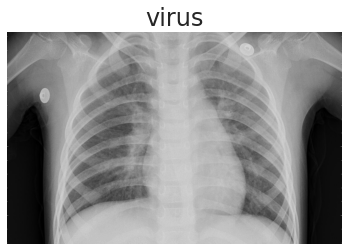

In [96]:
img = view_image("/content/COVID_IEEE/","virus")

['normal_original_IM-0432-0001.jpeg_d6a15803-fd06-4bb4-b859-3fea5f712c38.jpeg']
image shape (1228, 1480)


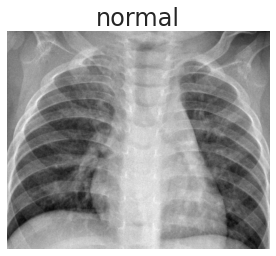

In [104]:
img = view_image("/content/COVID_IEEE/","normal")

['covid_original_covid1900240.png_1a4de419-1828-4821-846b-262aa670c42f.png']
image shape (480, 640, 3)


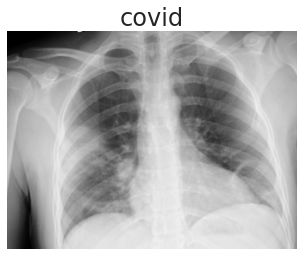

In [140]:
img = view_image("/content/COVID_IEEE/","covid")

# Developed CNN

In [39]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0005)

In [40]:
model = Sequential()

#Block Number 1
model.add(Conv2D(input_shape = (224,224,3), filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(MaxPool2D((2,2)))


#Block Number 2
model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))
model.add(MaxPool2D((2,2)))
Dropout(0.20)

#Block Number 3
model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))
Dropout(0.20)

#Block Number 4
model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))

Dropout(0.40)


# Fully Connected layer
model.add(Flatten())

model.add(Dense(units=1024, activation="relu"))

model.add(Dense(units= 256, activation="relu"))
model.add(Dense(units=128, activation="relu"))
Dropout(0.40)

model.add(Dense(units=3, activation="softmax"))

In [41]:
model.compile(optimizer = opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [42]:
history1 = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs=20
)

Epoch 1/20
88/88 [==============================] - 44s 178ms/step - loss: 0.9177 - accuracy: 0.5685 - val_loss: 0.4241 - val_accuracy: 0.8309
Epoch 2/20
88/88 [==============================] - 10s 117ms/step - loss: 0.4629 - accuracy: 0.8125 - val_loss: 0.2922 - val_accuracy: 0.8883
Epoch 3/20
88/88 [==============================] - 10s 117ms/step - loss: 0.3306 - accuracy: 0.8791 - val_loss: 0.4378 - val_accuracy: 0.8252
Epoch 4/20
88/88 [==============================] - 10s 118ms/step - loss: 0.2944 - accuracy: 0.8934 - val_loss: 0.2031 - val_accuracy: 0.9255
Epoch 5/20
88/88 [==============================] - 11s 120ms/step - loss: 0.2177 - accuracy: 0.9166 - val_loss: 0.2391 - val_accuracy: 0.9198
Epoch 6/20
88/88 [==============================] - 11s 121ms/step - loss: 0.1803 - accuracy: 0.9360 - val_loss: 0.1568 - val_accuracy: 0.9427
Epoch 7/20
88/88 [==============================] - 11s 121ms/step - loss: 0.1512 - accuracy: 0.9474 - val_loss: 0.2288 - val_accuracy: 0.9097

Text(0.5, 1.0, 'Accuracy Curves')

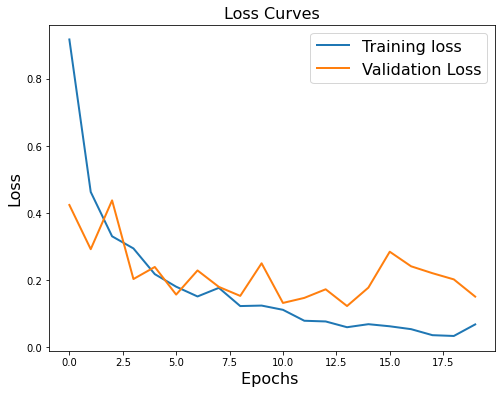

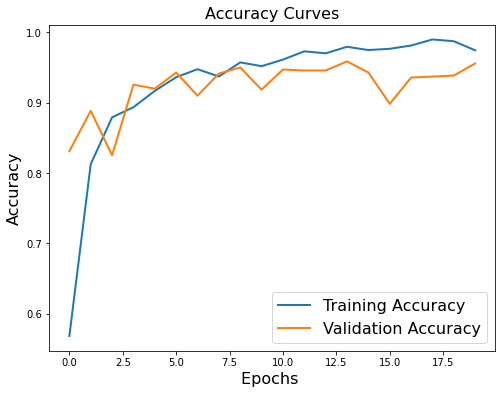

In [43]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['loss'],linewidth=2.0)
plt.plot(history1.history['val_loss'],linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['accuracy'],linewidth=2.0)
plt.plot(history1.history['val_accuracy'],linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

**Model Evaluation**

In [86]:
from tensorflow.keras.models import Model
a = np.array(history1.history['accuracy']).mean()
history1.history
model.evaluate_generator(generator=validation_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


[0.1506965458393097, 0.9555873870849609]

# Train Test Labeling for classification Report

In [45]:
import seaborn as sns

In [46]:
train_label =np.concatenate([y for x, y in train_ds], axis = 0)
print(train_label.shape)

test_label =np.concatenate([y for x, y in validation_ds], axis = 0)
print(test_label.shape)

(2795,)
(698,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Confusion Matrix
[[184   5   6]
 [  0 231  12]
 [  2   6 252]]


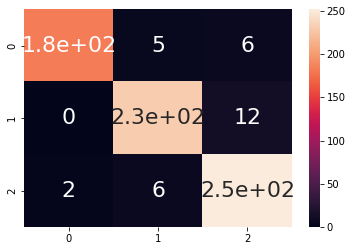

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
Y_pred = model.predict_generator(validation_ds, 1600)
y_pred = np.argmax(Y_pred, axis =1)
print("Confusion Matrix")
Cm = confusion_matrix(test_label,y_pred)
print(Cm)
sns.heatmap(Cm, annot = True, annot_kws={'size': 22})

# Classification Report

In [48]:
print('Classification Report')
target_names=['covid', 'normal', 'virus']
print(classification_report(test_label, y_pred, target_names = target_names))

Classification Report
              precision    recall  f1-score   support

       covid       0.99      0.94      0.97       195
      normal       0.95      0.95      0.95       243
       virus       0.93      0.97      0.95       260

    accuracy                           0.96       698
   macro avg       0.96      0.95      0.96       698
weighted avg       0.96      0.96      0.96       698



In [49]:
test_label.shape

(698,)

In [50]:
y_pred.shape

(698,)

**Saving the model**

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
model.save("/content/drive/MyDrive/model.hdf5")

# Confusion Matrix

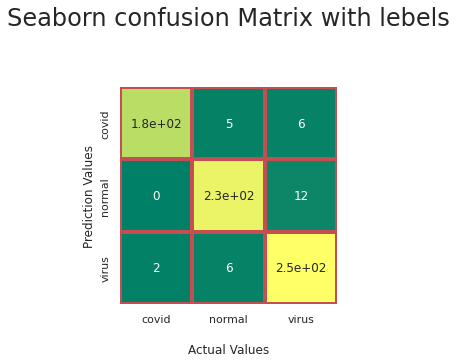

In [51]:
import seaborn as sns
sns.set(font_scale = 1.0)
ax = sns.heatmap(Cm, annot= True, cmap = 'summer', cbar = False, linewidths=3, linecolor='r', square = True, xticklabels =target_names, yticklabels= target_names, mask= False, ax = None)

sns.set(font_scale = 2.0)
ax.set_title('Seaborn confusion Matrix with lebels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel("Prediction Values");

# Transfer Learning Model Inception V3

In [52]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [53]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = InceptionV3(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model1 = Model(inputs = base_model.inputs, outputs = predictions)

87910968/87910968 [==============================] - 1s 0us/step


In [54]:
model1.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [55]:
history2 = model1.fit(
    train_ds,
    validation_data = validation_ds,
    epochs=20
)

Epoch 1/20
88/88 [==============================] - 36s 287ms/step - loss: 0.3615 - accuracy: 0.8522 - val_loss: 0.6374 - val_accuracy: 0.7192
Epoch 2/20
88/88 [==============================] - 20s 231ms/step - loss: 0.0933 - accuracy: 0.9699 - val_loss: 0.3136 - val_accuracy: 0.8854
Epoch 3/20
88/88 [==============================] - 20s 230ms/step - loss: 0.0360 - accuracy: 0.9896 - val_loss: 0.1084 - val_accuracy: 0.9685
Epoch 4/20
88/88 [==============================] - 20s 231ms/step - loss: 0.0109 - accuracy: 0.9979 - val_loss: 0.0918 - val_accuracy: 0.9799
Epoch 5/20
88/88 [==============================] - 21s 234ms/step - loss: 0.0267 - accuracy: 0.9911 - val_loss: 0.1622 - val_accuracy: 0.9542
Epoch 6/20
88/88 [==============================] - 20s 231ms/step - loss: 0.0198 - accuracy: 0.9932 - val_loss: 0.1583 - val_accuracy: 0.9699
Epoch 7/20
88/88 [==============================] - 20s 231ms/step - loss: 0.0253 - accuracy: 0.9918 - val_loss: 0.6157 - val_accuracy: 0.8997

# Classification Report

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Confusion Matrix
[[194   1   0]
 [  0 241   2]
 [  3   4 253]]


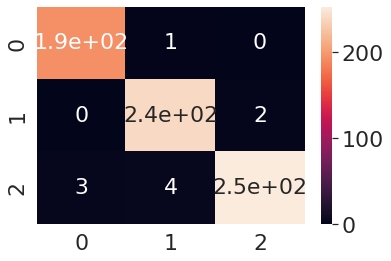

In [141]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
Y_pred = model1.predict_generator(validation_ds, 1600)
y_pred = np.argmax(Y_pred, axis =1)
print("Confusion Matrix")
Cm = confusion_matrix(test_label,y_pred)
print(Cm)
sns.heatmap(Cm, annot = True, annot_kws={'size': 22})

In [142]:
print('Classification Report')
target_names=['covid', 'normal', 'virus']
print(classification_report(test_label, y_pred, target_names = target_names))

Classification Report
              precision    recall  f1-score   support

       covid       0.98      0.99      0.99       195
      normal       0.98      0.99      0.99       243
       virus       0.99      0.97      0.98       260

    accuracy                           0.99       698
   macro avg       0.99      0.99      0.99       698
weighted avg       0.99      0.99      0.99       698



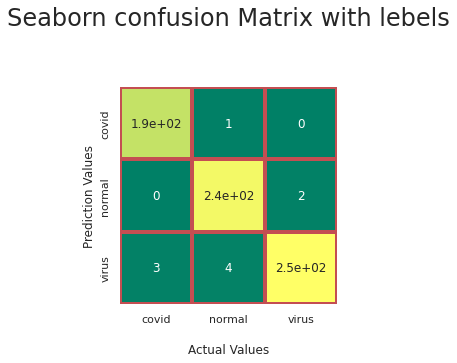

In [143]:
import seaborn as sns
sns.set(font_scale = 1.0)
ax = sns.heatmap(Cm, annot= True, cmap = 'summer', cbar = False, linewidths=3, linecolor='r', square = True, xticklabels =target_names, yticklabels= target_names, mask= False, ax = None)

sns.set(font_scale = 2.0)
ax.set_title('Seaborn confusion Matrix with lebels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel("Prediction Values");

In [70]:
model1.save("/content/drive/MyDrive/model1.hdf5")

# DenseNet121

In [56]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [57]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = DenseNet121(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model2 = Model(inputs = base_model.inputs, outputs = predictions)

29084464/29084464 [==============================] - 0s 0us/step


In [58]:
model2.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [59]:
history3 = model2.fit(
    train_ds,
    validation_data = validation_ds,
    epochs= 20
)

Epoch 1/20
88/88 [==============================] - 52s 430ms/step - loss: 0.2656 - accuracy: 0.8952 - val_loss: 0.2442 - val_accuracy: 0.9054
Epoch 2/20
88/88 [==============================] - 32s 359ms/step - loss: 0.0432 - accuracy: 0.9864 - val_loss: 0.0650 - val_accuracy: 0.9842
Epoch 3/20
88/88 [==============================] - 32s 359ms/step - loss: 0.0160 - accuracy: 0.9957 - val_loss: 0.0261 - val_accuracy: 0.9928
Epoch 4/20
88/88 [==============================] - 31s 355ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.0195 - val_accuracy: 0.9943
Epoch 5/20
88/88 [==============================] - 32s 360ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9914
Epoch 6/20
88/88 [==============================] - 31s 357ms/step - loss: 9.8710e-04 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9943
Epoch 7/20
88/88 [==============================] - 31s 358ms/step - loss: 5.0474e-04 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy

In [71]:
model2.save("/content/drive/MyDrive/model2.hdf5")

# Classification Report

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Confusion Matrix
[[195   0   0]
 [  0 241   2]
 [  0   2 258]]


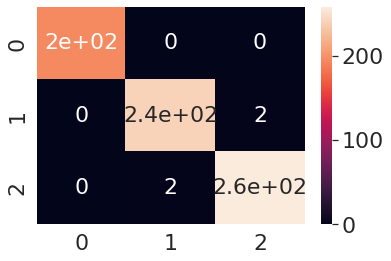

In [144]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
Y_pred = model2.predict_generator(validation_ds, 1600)
y_pred = np.argmax(Y_pred, axis =1)
print("Confusion Matrix")
Cm = confusion_matrix(test_label,y_pred)
print(Cm)
sns.heatmap(Cm, annot = True, annot_kws={'size': 22})

In [145]:
print('Classification Report')
target_names=['covid', 'normal', 'virus']
print(classification_report(test_label, y_pred, target_names = target_names))

Classification Report
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00       195
      normal       0.99      0.99      0.99       243
       virus       0.99      0.99      0.99       260

    accuracy                           0.99       698
   macro avg       0.99      0.99      0.99       698
weighted avg       0.99      0.99      0.99       698



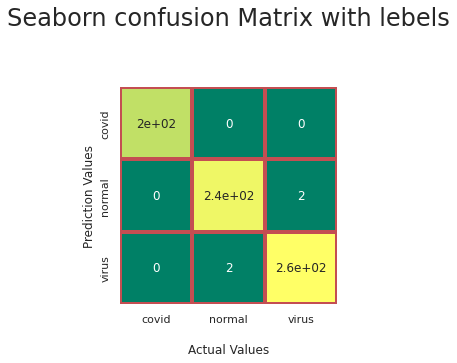

In [146]:
import seaborn as sns
sns.set(font_scale = 1.0)
ax = sns.heatmap(Cm, annot= True, cmap = 'summer', cbar = False, linewidths=3, linecolor='r', square = True, xticklabels =target_names, yticklabels= target_names, mask= False, ax = None)

sns.set(font_scale = 2.0)
ax.set_title('Seaborn confusion Matrix with lebels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel("Prediction Values");

# MobileNet

In [60]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [61]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = MobileNet(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model3 = Model(inputs = base_model.inputs, outputs = predictions)

17225924/17225924 [==============================] - 0s 0us/step


In [62]:
model3.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [63]:
history4 = model3.fit(
    train_ds,
    validation_data = validation_ds,
    epochs= 20
)

Epoch 1/20
88/88 [==============================] - 17s 145ms/step - loss: 0.3989 - accuracy: 0.8487 - val_loss: 3.7226 - val_accuracy: 0.4384
Epoch 2/20
88/88 [==============================] - 12s 135ms/step - loss: 0.0797 - accuracy: 0.9753 - val_loss: 2.2297 - val_accuracy: 0.5845
Epoch 3/20
88/88 [==============================] - 12s 134ms/step - loss: 0.0235 - accuracy: 0.9946 - val_loss: 1.0147 - val_accuracy: 0.7178
Epoch 4/20
88/88 [==============================] - 12s 132ms/step - loss: 0.0075 - accuracy: 0.9993 - val_loss: 0.2315 - val_accuracy: 0.9198
Epoch 5/20
88/88 [==============================] - 12s 133ms/step - loss: 0.0047 - accuracy: 0.9993 - val_loss: 0.1011 - val_accuracy: 0.9656
Epoch 6/20
88/88 [==============================] - 12s 133ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0985 - val_accuracy: 0.9670
Epoch 7/20
88/88 [==============================] - 12s 132ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0984 - val_accuracy: 0.9699

In [72]:
model3.save("/content/drive/MyDrive/model3.hdf5")

# Classification Report

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Confusion Matrix
[[192   1   2]
 [  0 236   7]
 [  2   7 251]]


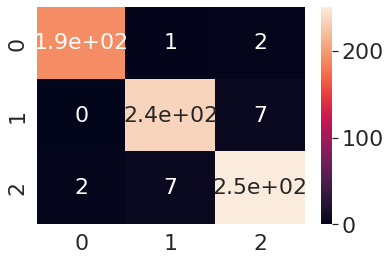

In [87]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
Y_pred = model3.predict_generator(validation_ds, 1600)
y_pred = np.argmax(Y_pred, axis =1)
print("Confusion Matrix")
Cm = confusion_matrix(test_label,y_pred)
print(Cm)
sns.heatmap(Cm, annot = True, annot_kws={'size': 22})

In [88]:
print('Classification Report')
target_names=['covid', 'normal', 'virus']
print(classification_report(test_label, y_pred, target_names = target_names))

Classification Report
              precision    recall  f1-score   support

       covid       0.99      0.98      0.99       195
      normal       0.97      0.97      0.97       243
       virus       0.97      0.97      0.97       260

    accuracy                           0.97       698
   macro avg       0.97      0.97      0.97       698
weighted avg       0.97      0.97      0.97       698



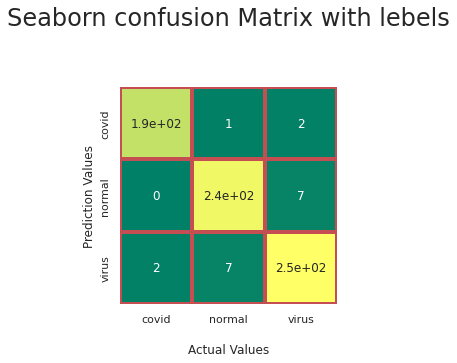

In [89]:
import seaborn as sns
sns.set(font_scale = 1.0)
ax = sns.heatmap(Cm, annot= True, cmap = 'summer', cbar = False, linewidths=3, linecolor='r', square = True, xticklabels =target_names, yticklabels= target_names, mask= False, ax = None)

sns.set(font_scale = 2.0)
ax.set_title('Seaborn confusion Matrix with lebels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel("Prediction Values");

# Ensemble Learning Model 1 (Developed CNN+ Inception V3 + DenseNet121)

In [67]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [73]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model("/content/drive/MyDrive/model.hdf5")
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model('/content/drive/MyDrive/model1.hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')

model_3 = load_model('/content/drive/MyDrive/model2.hdf5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

models = [model_1, model_2, model_3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [74]:
ensemble_model.compile(optimizer = opt, 
                       loss= tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics = ['accuracy'])

In [75]:
ensemble_history = ensemble_model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs =15
)

Epoch 1/15
88/88 [==============================] - 85s 740ms/step - loss: 0.0182 - accuracy: 0.9957 - val_loss: 0.1036 - val_accuracy: 0.9799
Epoch 2/15
88/88 [==============================] - 60s 681ms/step - loss: 0.0255 - accuracy: 0.9953 - val_loss: 0.0512 - val_accuracy: 0.9842
Epoch 3/15
88/88 [==============================] - 60s 688ms/step - loss: 0.0202 - accuracy: 0.9968 - val_loss: 0.0417 - val_accuracy: 0.9828
Epoch 4/15
88/88 [==============================] - 59s 676ms/step - loss: 0.0120 - accuracy: 0.9986 - val_loss: 0.0652 - val_accuracy: 0.9828
Epoch 5/15
88/88 [==============================] - 60s 679ms/step - loss: 0.0096 - accuracy: 0.9979 - val_loss: 0.0481 - val_accuracy: 0.9814
Epoch 6/15
88/88 [==============================] - 60s 679ms/step - loss: 0.0076 - accuracy: 0.9986 - val_loss: 0.0466 - val_accuracy: 0.9828
Epoch 7/15
88/88 [==============================] - 60s 679ms/step - loss: 0.0058 - accuracy: 0.9986 - val_loss: 0.0394 - val_accuracy: 0.9857

# Classification Report

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Confusion Matrix
[[194   1   0]
 [  0 236   7]
 [  2   2 256]]


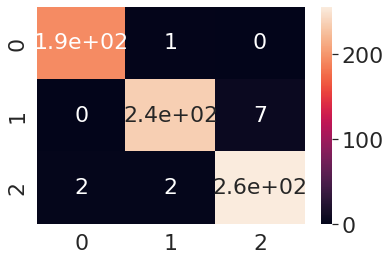

In [147]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict_generator(validation_ds, 1600)
y_pred = np.argmax(Y_pred, axis =1)
print("Confusion Matrix")
Cm = confusion_matrix(test_label,y_pred)
print(Cm)
sns.heatmap(Cm, annot = True, annot_kws={'size': 22})

In [148]:
print('Classification Report')
target_names=['covid', 'normal', 'virus']
print(classification_report(test_label, y_pred, target_names = target_names))

Classification Report
              precision    recall  f1-score   support

       covid       0.99      0.99      0.99       195
      normal       0.99      0.97      0.98       243
       virus       0.97      0.98      0.98       260

    accuracy                           0.98       698
   macro avg       0.98      0.98      0.98       698
weighted avg       0.98      0.98      0.98       698



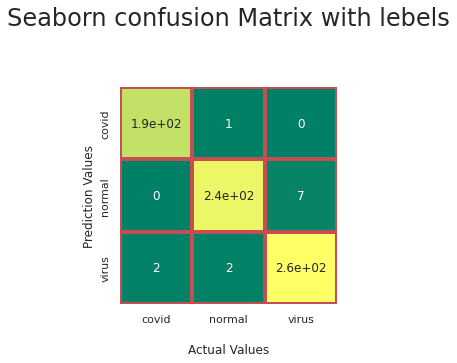

In [149]:
import seaborn as sns
sns.set(font_scale = 1.0)
ax = sns.heatmap(Cm, annot= True, cmap = 'summer', cbar = False, linewidths=3, linecolor='r', square = True, xticklabels =target_names, yticklabels= target_names, mask= False, ax = None)

sns.set(font_scale = 2.0)
ax.set_title('Seaborn confusion Matrix with lebels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel("Prediction Values");